# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [ ]:
import os
os.environ['OMP_NUM_THREADS']='1'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dt = dls.train
xb,yb = next(iter(dt))

In [ ]:
betamin,betamax,n_steps = 0.0001,0.01,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

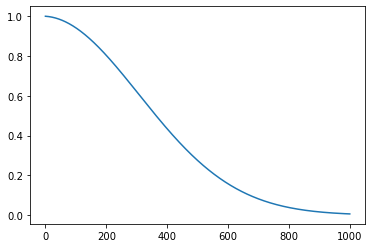

In [ ]:
plt.plot(alphabar);

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([471,  12, 286, 306,   8, 103, 433, 836, 167, 966, 783, 539, 114, 819,
        405, 378, 346, 706, 430, 621, 125, 316,   6, 653, 789])

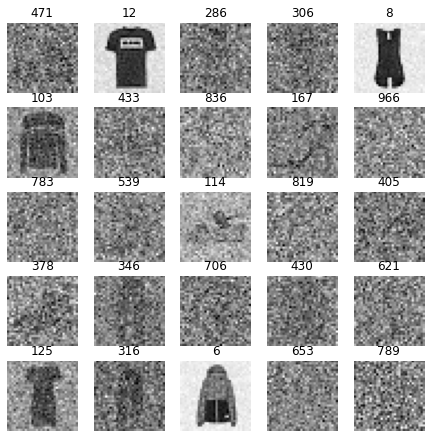

In [ ]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

In [ ]:
from diffusers import UNet2DModel

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
lr = 1e-2
epochs = 8
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.276,0,train
0.043,0,eval
0.038,1,train
0.037,1,eval
0.031,2,train
0.031,2,eval
0.028,3,train
0.028,3,eval
0.027,4,train
0.027,4,eval


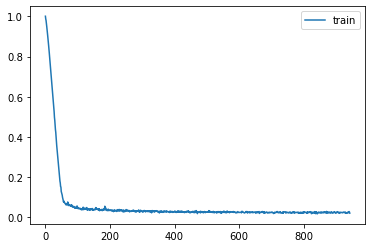

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')

In [ ]:
# torch.save(learn.model, mdl_path/'fashion_ddpm3.pkl')

In [ ]:
model = torch.load(mdl_path/'fashion_ddpm3.pkl').cuda()

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.clamp(0,1).float().cpu())
    return preds

In [ ]:
n_samples = 2048

In [ ]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 4min 20s, sys: 1.66 s, total: 4min 22s
Wall time: 4min 21s


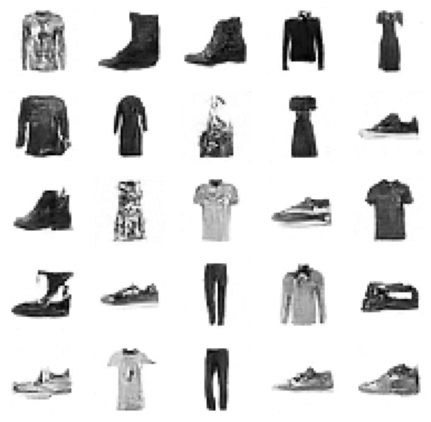

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
from timm import models

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug.pkl')
del(cmodel[8])
del(cmodel[7])

In [ ]:
from miniai.fid import FID

In [ ]:
fid = FID(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
fid(samples[-1])

3.5030921116560307

In [ ]:
fid(xb)

1.291420794191481

### Skip sampling

In [ ]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t==0: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().clamp(0,1))
    return preds

In [ ]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 1min 32s, sys: 2.37 s, total: 1min 35s
Wall time: 1min 35s


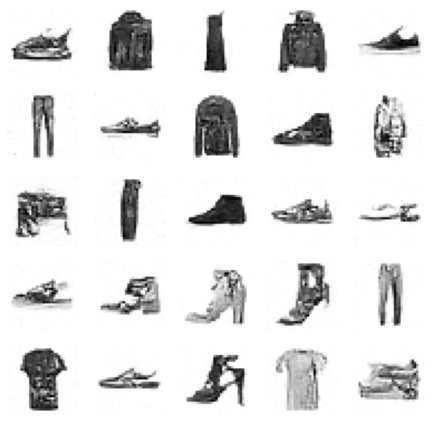

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
fid(samples[-1])

7.586786759710208

In [ ]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.clamp(0,1).float().cpu())
    return preds

In [ ]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 1min 23s, sys: 155 ms, total: 1min 23s
Wall time: 1min 23s


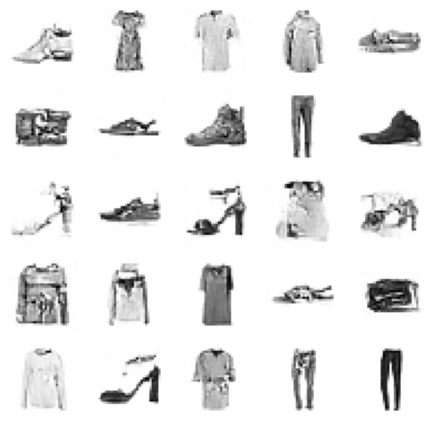

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

In [ ]:
fid(samples[-1])

12.0880025752287

In [ ]:
@torch.no_grad()
def sample3(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if (t%3==0) or t<150: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.clamp(0,1).float().cpu())
    return preds

In [ ]:
%%time
samples = sample3(model, (n_samples, 1, 32, 32))

CPU times: user 1min 58s, sys: 51.3 ms, total: 1min 58s
Wall time: 1min 58s


In [ ]:
fid(samples[-1])

5.786424101228988

In [ ]:
def model_fid(fname, f=sample3):
    model = torch.load(mdl_path/fname).cuda()
    return fid(f(model, (n_samples, 1, 32, 32))[-1])

In [ ]:
model_fid('fashion_ddpm3.pkl')

6.851471881614771

In [ ]:
model_fid('fashion_ddpm3.pkl', sample)

3.636547839903102

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
model_fid('fashion_ddpm_mp.pkl')

6.688676996630591

In [ ]:
model_fid('fashion_ddpm_mp.pkl', sample)

3.713542607433169

In [ ]:
model_fid('fashion_no-t.pkl')

13.634880574010538

In [ ]:
model_fid('fashion_no-t.pkl', sample)

6.714083333602815

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    t = np.random.triangular(0, 0.5, 1, (n,))*n_steps
    t = tensor(t, dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

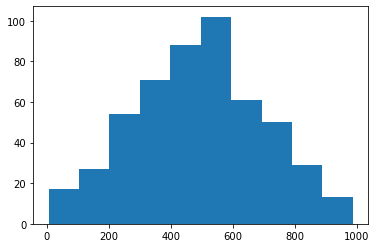

In [ ]:
(xt,t),ε = noisify(xb,alphabar)
plt.hist(t);

## cos schedule

In [ ]:
def abar(t, T, s):
    def f(t_): return ((t_/T+s)/(1+s)*(math.pi/2)).cos()**2
    return f(t)/f(0)

In [ ]:
def cos_sched(t, T=1000, s=0.008):
    T = tensor(T)
    return (1-abar(t,T,s)/abar(t-1,T,s)).clamp(max=0.999)

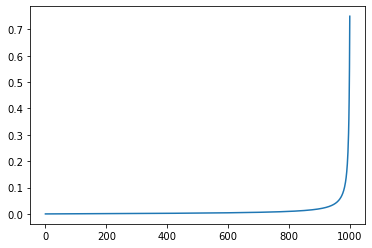

In [ ]:
xs = torch.linspace(0, 999, 1000)
plt.plot(xs, cos_sched(xs));

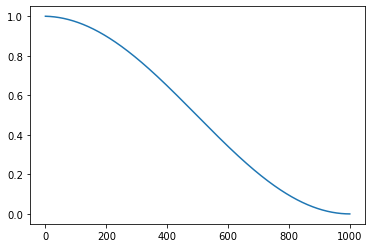

In [ ]:
plt.plot(xs, torch.cumprod(1-cos_sched(xs), 0));

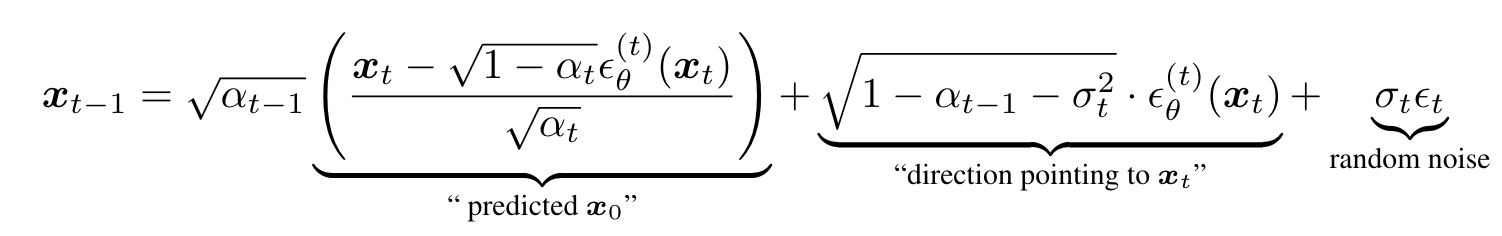